In [1]:
from project1_model import project1_model
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
# from torch.utils.data import SubsetRandomSampler
# from sklearn.model_selection import train_test_split

In [2]:
trans_train = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.RandomCrop(32, padding=4),
    # Flip horizontal
    transforms.RandomHorizontalFlip(),
    # transforms.GaussianBlur(kernel_size=3, sigma=(2.0, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262]),
    # transform_random,
])

trans_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262]),
])

batch_size = 128
epochs = 48
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainData = torchvision.datasets.CIFAR10('./cifar-10-data/',train=True,download=True, transform=trans_train)
trainDataLoader = torch.utils.data.DataLoader(trainData, batch_size = batch_size, shuffle = True) # , num_worker = 1

testData = torchvision.datasets.CIFAR10('./cifar-10-data/',train=False,download=True, transform=trans_test)
testDataLoader = torch.utils.data.DataLoader(testData, batch_size = batch_size, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(len(trainData))
print(len(testData))
# image, label = trainData[2]
# datasize = image.shape
label = 10
# print(datasize, label)
# labelNum = label

50000
10000


In [4]:
res18 = project1_model().to(device)

print('model structure: ', res18)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

model structure:  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, mom

In [5]:
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR, StepLR

# init optimizer
optimizer = torch.optim.Adam(res18.parameters(), lr=1e-3) # , weight_decay=1e-4
# optimizer = torch.optim.SGD(res18.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)

# scheduler = ExponentialLR(optimizer, gamma=0.6)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

# set loss function
criterion = nn.CrossEntropyLoss()

def train(model, epochs):
    # train_loss = []
    epoch_loss_i = []
    
    correct = 0
    
    for batch_idx, (data, target) in enumerate(trainDataLoader):
        # data, target = Variable(data).to(device), Variable(target).to(device)    # to device
        data, target = data.to(device), target.to(device)
        train_pred = model(data)
        
        # Accuracy
        pred = train_pred.argmax(dim=1)
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        # Loss
        train_loss_i = criterion(train_pred, target)
        epoch_loss_i.append(train_loss_i)
        
        # Backpropagation
        optimizer.zero_grad()
        train_loss_i.backward()
        optimizer.step()
        
    # print('Train epoch: {} | [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(batch_idx, batch_idx * len(data), len(trainDataLoader), 100. * batch_idx/len(trainDataLoader), epoch_loss))
    epoch_loss = sum(epoch_loss_i)/len(epoch_loss_i)
    # trainAcc = correct / len(epoch_loss_i)
    trainAcc = correct / (len(trainDataLoader.dataset))
    # print('Train epoch: {} | [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epochs, batch_idx * len(data), len(trainDataLoader), 100. * batch_idx/len(trainDataLoader), epoch_loss))
    
    # get learing rate
    print(get_lr(optimizer))
    
    return epoch_loss, trainAcc
    # print('Train epoch: {} | [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(i, batch_idx * len(data), len(trainDataLoader), 100. * batch_idx/len(trainDataLoader), epoch_loss))


def test(model):
    
    # model.eval()
    # test_loss = []
    # for i in epochs:
    test_loss_i = []
    correct = 0
    testAcc = 0
    total = 0

    for data, target in testDataLoader:
        data, target = data.to(device), target.to(device) # (rm , volatile=True) .to(device)
        test_pred = model(data)
        test_loss_i.append(criterion(test_pred, target))
        
        pred = test_pred.argmax(dim=1)
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        total += target.size(0)

    # test_loss_i = test_loss_i / len(testDataLoader.dataset) # len(testDataLoader.dataset)
    test_loss = sum(test_loss_i) / len(test_loss_i)
    testAcc = correct / total # len(testDataLoader.dataset)
    
    print('Test set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(test_loss, correct, len(testDataLoader.dataset), 100. * correct / len(testDataLoader.dataset)))

    return test_loss, testAcc

In [6]:
import os

def save(net, path):
    """
        save parameters into files after training
        :param: net model, model save path
        :return: None
    """
    stats = {
        # 'epoch': epoch,
        'model': net.state_dict()
    }
    if not os.path.exists(path):
        os.mkdir(path)

    savePath = os.path.join(path, 'res18')   ##### model_res18  /  model_CNN  /   model_wasteCNN
    torch.save(stats, savePath)
    print("Final model checkpoints in {}".format(savePath))

In [7]:
import datetime

train_loss = []
test_loss = []
train_acc = []
test_acc = []


for epoch in range(epochs):
    starttime = datetime.datetime.now()
    trainLoss, trainAcc = train(res18, epoch)
    train_loss.append(trainLoss)
    train_acc.append(trainAcc)
    
    traintime = datetime.datetime.now()
    
    # if epoch % 5 == 0:
    scheduler.step()
    
    scheduletime = datetime.datetime.now()
    print('Train set: Epoch: {} Loss: {:.6f} Accuracy: {:.2f}'.format(epoch, trainLoss, trainAcc))
    
    with torch.no_grad():
        testLoss, testAcc = test(res18) #.detach()
        test_loss.append(testLoss)
        test_acc.append(testAcc)
        print('Test set: Epoch: {} Loss: {:.6f} Accuracy: {:.2f}'.format(epoch, testLoss, testAcc))
        endtime = datetime.datetime.now()
        print("train time:", traintime-starttime, "test time:", endtime-scheduletime, "total time:", endtime-starttime, "\n")

        if len(test_acc) <= 2:
            model_scripted = torch.jit.script(res18) # Export to TorchScript
            model_scripted.save('./project1_model/res18.pt') # Save
        elif testAcc > max(test_acc[:-1]):
            #print(len(test_acc))
            model_scripted = torch.jit.script(res18)
            model_scripted.save('./project1_model/res18.pt') # Save


0.001
Train set: Epoch: 0 Loss: 1.437571 Accuracy: 0.47
Test set: Average Loss: 1.1859, Accuracy: 5790/10000 (58%)
Test set: Epoch: 0 Loss: 1.185929 Accuracy: 0.58
train time: 0:00:50.241091 test time: 0:00:05.358641 total time: 0:00:55.599899 

0.001
Train set: Epoch: 1 Loss: 0.962872 Accuracy: 0.66
Test set: Average Loss: 0.9133, Accuracy: 6791/10000 (68%)
Test set: Epoch: 1 Loss: 0.913313 Accuracy: 0.68
train time: 0:00:49.387046 test time: 0:00:05.472621 total time: 0:00:54.859814 

0.001
Train set: Epoch: 2 Loss: 0.769634 Accuracy: 0.73
Test set: Average Loss: 0.7708, Accuracy: 7315/10000 (73%)
Test set: Epoch: 2 Loss: 0.770840 Accuracy: 0.73
train time: 0:00:49.229447 test time: 0:00:05.437563 total time: 0:00:54.667126 

0.001
Train set: Epoch: 3 Loss: 0.640933 Accuracy: 0.78
Test set: Average Loss: 0.6590, Accuracy: 7773/10000 (78%)
Test set: Epoch: 3 Loss: 0.659045 Accuracy: 0.78
train time: 0:00:49.365225 test time: 0:00:05.363465 total time: 0:00:54.728855 

0.001
Train set:

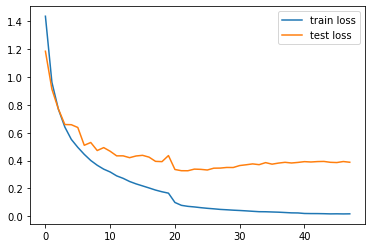

In [8]:
import matplotlib.pyplot as plt

# print(len(train_loss), len(test_loss))
x_axis = np.arange(epochs) # epochs
plt.plot(x_axis, train_loss, label='train loss')
plt.plot(x_axis, test_loss, label='test loss')
plt.legend()
plt.savefig('loss_pic.png')
plt.show()

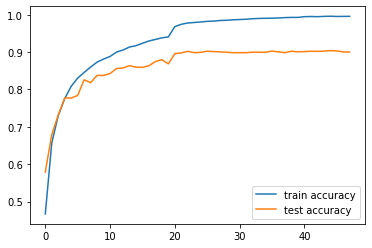

tensor(0.9040) 44


In [9]:
x_axis = np.arange(epochs)
# train_acc_array = [x/50000 for x in train_acc]
# plt.plot(x_axis, train_acc_array, label='train accuracy')
plt.plot(x_axis, train_acc, label='train accuracy')
plt.plot(x_axis, test_acc, label='test accuracy')
plt.legend()
plt.savefig('accuracy_pic.png')
plt.show()
print(max(test_acc), test_acc.index(max(test_acc)))

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(res18)/1000000, "M")

2.777674 M
